In [1]:
%matplotlib inline
import os
import re
import io

import matplotlib
import numpy as np
import pandas as pd
import xarray as xr

import climatools.html.html as climahtml
import climatools.scripts.g1_threshold as scripts

import IPython.display as display

import imp
imp.reload(scripts)

/chia_cluster/home/jackyu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'climatools.scripts.g1_threshold' from '/chia_cluster/home/jackyu/climatools/climatools/scripts/g1_threshold.py'>

In [2]:
%run params.py

In [3]:
# for printing some input parameters

def innames():
    return ['vstar', 'nband', 'nv', 'dv',
            'flgh2o',
            'tsfc',
            'pressure_reference_1',
            'temperature_reference_1', 
            'pressure_reference_2', 
            'temperature_reference_2',
            'ighigh', 
            'ng', 
            'nref',
            'p_refs',
            't_refs',
            'ng_refs',
            'absth',
            'wgt',
            'option_wgt_flux',
            'option_wgt_k',
            'option_klin',
            'fac_meank',
            'klin']



def pattern_assign(name):
    return ''' 
    parameter .* :: \s* &? \s* ({} \s* = .* \n)
    '''.format(name)

def pattern_data(name):
    return '''
    (data [^/{name}]+ {name}[^,] [^/{name}]+ / [^/]+ /)
    '''.format(name=name)

def pattern_atmpro():
    return '''
    (atmosphere_profiles/.*75_r8.pro)
    '''
    

def get_input_params(code, names):
    results = []
    for name in names:
        regex = re.compile(pattern_assign(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
        regex = re.compile(pattern_data(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
    regex = re.compile(pattern_atmpro(), re.VERBOSE)
    results.extend(regex.findall(code))
        
    results = [result.replace('_r8', '') for result in results]
    return results


In [4]:
analysis = scripts.Analysis()

In [5]:
crd = analysis.model('crd')
crd.type_model = 'crd'
crd.rundir = DIR_CRD
crd.fpath_flux = 'output_fluxg.dat'
crd.fpath_coolr = 'output_coolrg.dat'
crd.linestyle = '-'
crd.load_data()

In [6]:
iggs = [1, 5, 9]
linestyles = ['--', '-.', ':']

df_wfluxg = pd.read_csv(os.path.join(crd.rundir, 'output_wfluxg.dat'), 
                 sep=r'\s+')

df_wcoolrg = pd.read_csv(os.path.join(crd.rundir, 'output_wcoolrg.dat'), 
                 sep=r'\s+')

for igg, linestyle in zip(iggs, linestyles):

    flux_igg = df_wfluxg[df_wfluxg['igg'] == igg].drop('igg', axis=1)
    s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

    coolr_igg = df_wcoolrg[df_wcoolrg['igg'] == igg].drop('igg', axis=1)
    s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))


    crdx_igg = analysis.model('wgt_igg{}'.format(igg))
    crdx_igg.type_model = 'crd'
    crdx_igg.rundir = DIR_XCRD
    crdx_igg.fpath_flux = s_flux
    crdx_igg.fpath_coolr = s_coolr
    crdx_igg.linestyle = linestyle
    crdx_igg.load_data()

In [7]:
fig = analysis.fig_fluxcoolr('fig1', vartypes=['cooling rate'])
fig.ggroups = list(crd.data['dgdgs'].coords['g'].values) #list(range(1, 8 + 1))
fig.vars_plot['flux'] = ['flug', 'fnetg']
fig.vars_plot['cooling rate'] = ['coolrg']
fig.colors['flug'] = 'darkred'
fig.colors['fnetg'] = 'lightcoral'
fig.colors['coolrg'] = 'blue'
fig.varlims_from_indexrange['linear'] = (50, 1050)
fig.varlims_from_indexrange['log'] = (1e-2, 200)

fig.set_pressure_displayrange(low=1e-2)

In [8]:
table_fluxg = analysis.table('table_fluxg')
table_fluxg.sumg = False
table_fluxg.vartype = 'flux'
table_fluxg.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolrg = analysis.table('table_coolrg')
table_coolrg.vartype = 'cooling rate'
table_coolrg.sumg = False
table_coolrg.at_pressures = crd.data['cooling rate']\
                               .coords['pressure']\
                               .isel(pressure=[0, -1])


In [9]:
table_flux = analysis.table('table_flux')
table_flux.sumg = True
table_flux.vartype = 'flux'
table_flux.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolr = analysis.table('table_coolr')
table_coolr.vartype = 'cooling rate'
table_coolr.sumg = True
table_coolr.at_pressures = crd.data['cooling rate']\
                              .coords['pressure']\
                              .isel(pressure=[0, -1])

In [10]:
table_dgdgs = analysis.table('dgdgs')
table_dgdgs.vartype = 'dgdgs'
table_dgdgs.sumg = False

In [11]:
with open(os.path.join(crd.rundir, 'lblnew.f'), 
          mode='r', encoding='utf-8') as f:
    c = f.read()

print('\n\n'.join(get_input_params(c, innames())))

vstar = 1215

nband = 165

nv = 200

dv = 0.005

tsfc =294

ng =7

nref =1

p_refs = (/ 600 /) 

t_refs = (/ 250 /) 

ng_refs = (/ 7 /) 

data wgt
     &     /0.5 , 0.5 , 0.5 , 0.5,
     &     0.5 , 0.5 , 0.9/

option_wgt_flux =2

option_wgt_k =1

option_klin =1

klin =5e-25

atmosphere_profiles/mls75.pro


In [12]:
fig.display_hrefanchor()

In [13]:
table_fluxg.display_hrefanchor()
table_coolrg.display_hrefanchor()

table_flux.display_hrefanchor()
table_coolr.display_hrefanchor()

In [14]:
table_dgdgs.display_hrefanchor()

In [15]:
s_abscom = 'Overall absth'
display.HTML(climahtml.getHTML_hrefanchor(s_abscom))

In [16]:
s_ggroup_summary = 'g-group summary'
display.HTML(climahtml.getHTML_hrefanchor(s_ggroup_summary))

In [17]:
#for g in range(1, 20 + 1):
#    s = 'Table: cooling rate. g-group {}'.format(g)
#    html = climahtml.getHTML_hrefanchor(s)
#    display.display(display.HTML(html))

# Figure: cooling rate g-group 1

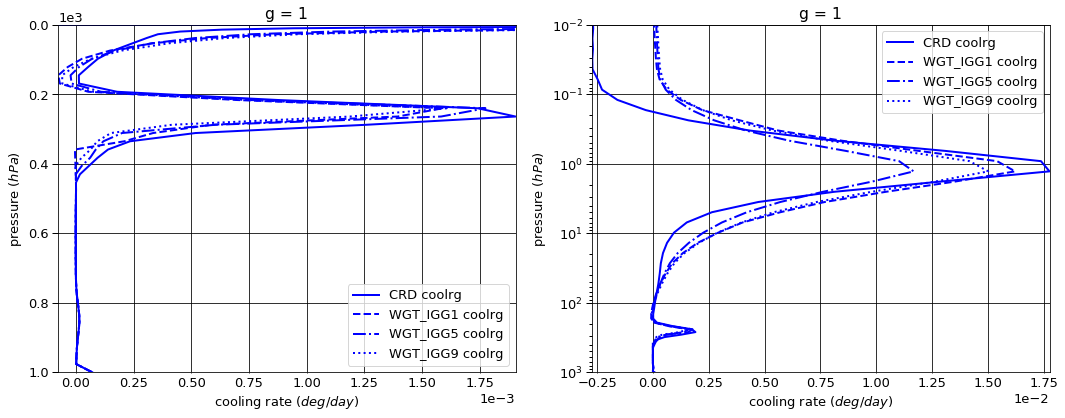

# Figure: cooling rate g-group 2

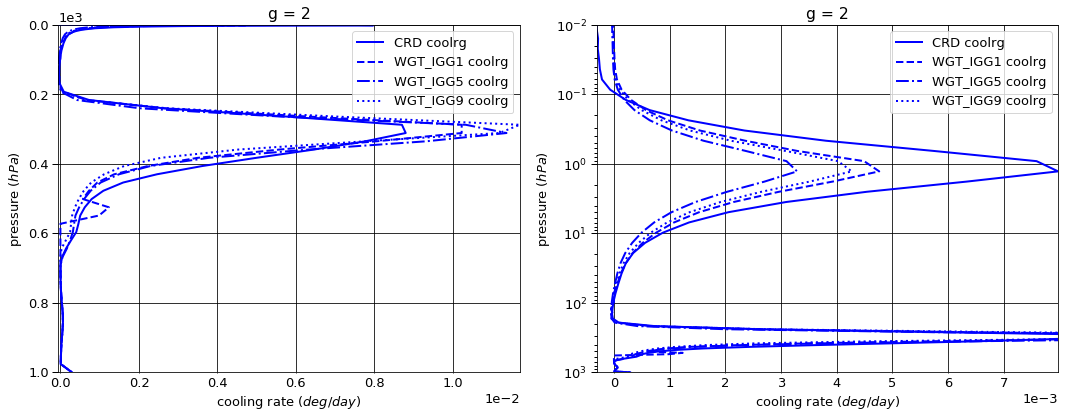

# Figure: cooling rate g-group 3

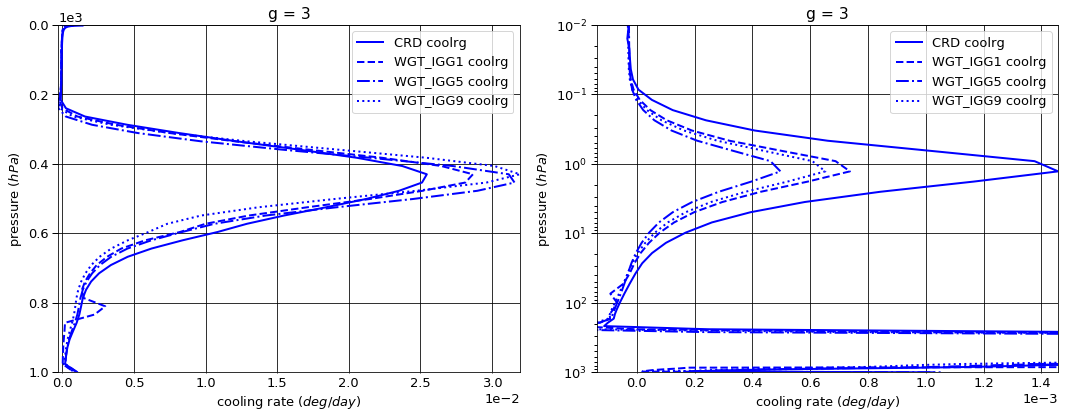

# Figure: cooling rate g-group 4

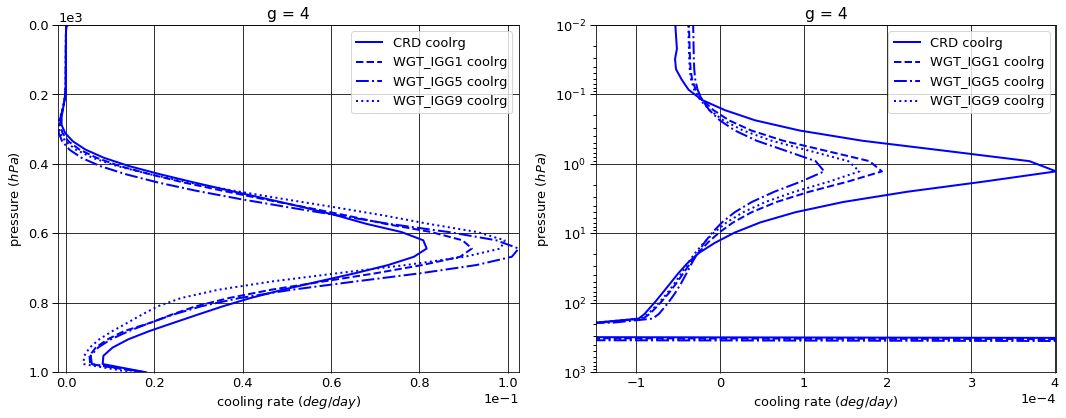

# Figure: cooling rate g-group 5

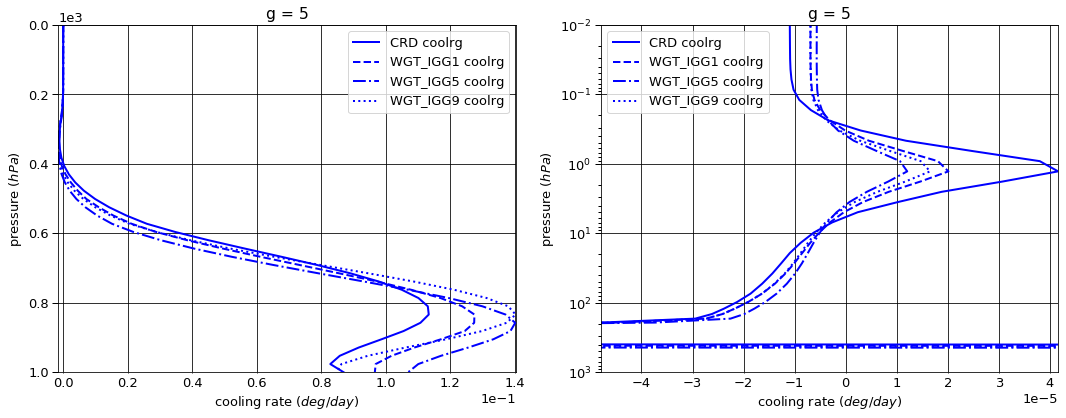

# Figure: cooling rate g-group 6

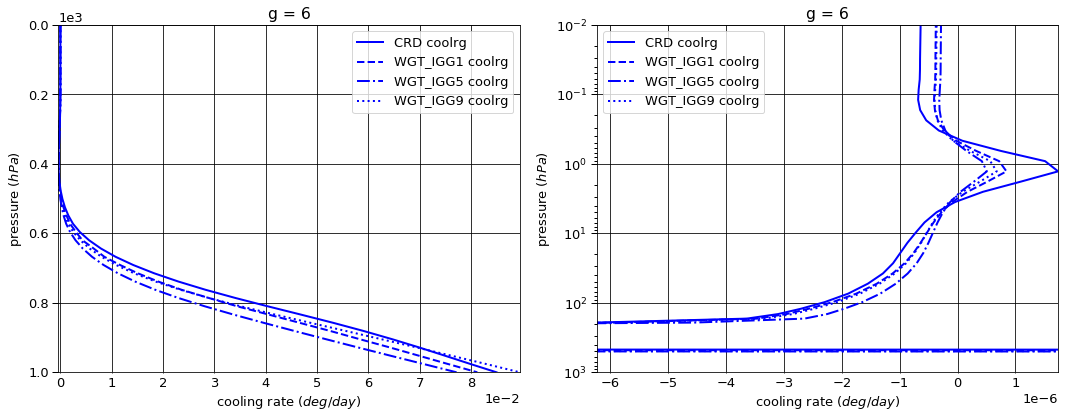

# Figure: cooling rate g-group 7

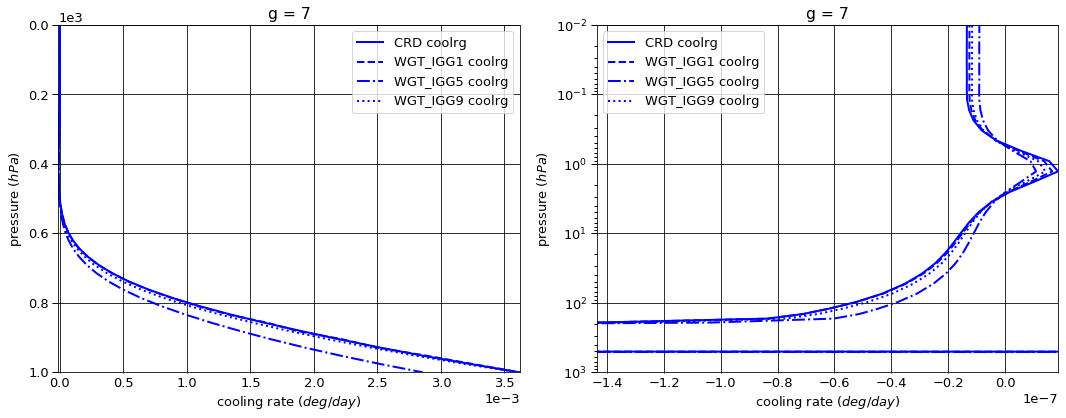

# Figure: cooling rate g-group total

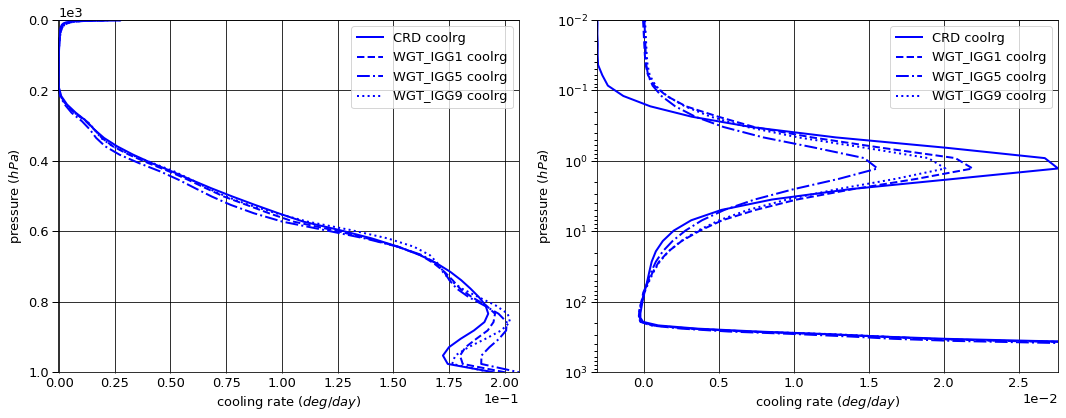

In [18]:
matplotlib.rcParams.update({'font.size': 13,
                            'grid.color': 'black',
                            'axes.facecolor': 'white',
                            'axes.edgecolor': 'black',
                            'ytick.direction': 'out',
                            'ytick.major.size': 6, 'ytick.major.width': 1,
                            'ytick.minor.size': 3, 'ytick.minor.width': 1,
                            'xtick.direction': 'out',
                            'xtick.major.size': 6, 'xtick.major.size': 1,
                            'xtick.minor.size': 3, 'xtick.minor.size': 1}) 

fig.plot(analysis)


In [19]:
table_fluxg.display_withdiff(analysis, benchmark='crd')
table_coolrg.display_withdiff(analysis, benchmark='crd')
table_flux.display_withdiff(analysis, benchmark='crd')
table_coolr.display_withdiff(analysis, benchmark='crd')

# Table: flux. g-groups 


CRD


flug      fldg     fnetg
g pressure level                              
1 0.0      1     -0.029151  0.000000 -0.029151
  1013.0   76    -0.196682  0.196484 -0.000198
2 0.0      1     -0.169984  0.000000 -0.169984
  1013.0   76    -0.812841  0.812034 -0.000807
3 0.0      1     -0.782185  0.000000 -0.782185
  1013.0   76    -2.351924  2.349241 -0.002683
4 0.0      1     -3.194676  0.000000 -3.194676
  1013.0   76    -6.124332  6.061465 -0.062866
5 0.0      1     -5.639196  0.000000 -5.639196
  1013.0   76    -7.530232  6.536654 -0.993578
6 0.0      1     -5.428497  0.000000 -5.428497
  1013.0   76    -5.873380  2.480985 -3.392395
7 0.0      1     -0.854279  0.000000 -0.854279
  1013.0   76    -0.865785  0.078471 -0.787314


WGT_IGG1


flug      fldg     fnetg
g pressure level                              
1 0.0      1     -0.027347  0.000000 -0.027347
  1013.0   76    -0.196682  0.196484 -0.000198
2 0.0      1     -0.161326  0.000000 -0.161326
  1013.0   76    -0.812841  0.812034 -0.000807
3 0.0      1     -0.761895  0.000000 -0.761895
  1013.0   76    -2.351924  2.349606 -0.002319
4 0.0      1     -3.172851  0.000000 -3.172851
  1013.0   76    -6.124332  6.073118 -0.051213
5 0.0      1     -5.709879  0.000000 -5.709879
  1013.0   76    -7.530232  6.718804 -0.811428
6 0.0      1     -5.489598  0.000000 -5.489598
  1013.0   76    -5.873380  2.202587 -3.670792
7 0.0      1     -0.854333  0.000000 -0.854333
  1013.0   76    -0.865785  0.078361 -0.787424


WGT_IGG5


flug      fldg     fnetg
g pressure level                              
1 0.0      1     -0.026525  0.000000 -0.026525
  1013.0   76    -0.196682  0.196484 -0.000198
2 0.0      1     -0.165622  0.000000 -0.165622
  1013.0   76    -0.812841  0.812034 -0.000807
3 0.0      1     -0.785763  0.000000 -0.785763
  1013.0   76    -2.351924  2.349216 -0.002709
4 0.0      1     -3.274449  0.000000 -3.274449
  1013.0   76    -6.124332  6.072003 -0.052329
5 0.0      1     -5.868806  0.000000 -5.868806
  1013.0   76    -7.530232  6.671800 -0.858432
6 0.0      1     -5.567329  0.000000 -5.567329
  1013.0   76    -5.873380  1.883302 -3.990078
7 0.0      1     -0.857409  0.000000 -0.857409
  1013.0   76    -0.865785  0.058938 -0.806847


WGT_IGG9


flug      fldg     fnetg
g pressure level                              
1 0.0      1     -0.026418  0.000000 -0.026418
  1013.0   76    -0.196682  0.196484 -0.000198
2 0.0      1     -0.157430  0.000000 -0.157430
  1013.0   76    -0.812841  0.812034 -0.000807
3 0.0      1     -0.741795  0.000000 -0.741795
  1013.0   76    -2.351924  2.349606 -0.002319
4 0.0      1     -3.099906  0.000000 -3.099906
  1013.0   76    -6.124332  6.083915 -0.040417
5 0.0      1     -5.628921  0.000000 -5.628921
  1013.0   76    -7.530232  6.985749 -0.544483
6 0.0      1     -5.491234  0.000000 -5.491234
  1013.0   76    -5.873380  2.293075 -3.580305
7 0.0      1     -0.855076  0.000000 -0.855076
  1013.0   76    -0.865785  0.074984 -0.790802


WGT_IGG1 - CRD


flug      fldg         fnetg
g pressure level                                  
1 0.0      1      0.001804  0.000000  1.804101e-03
  1013.0   76     0.000000  0.000000  2.710505e-20
2 0.0      1      0.008657  0.000000  8.657360e-03
  1013.0   76     0.000000  0.000000  0.000000e+00
3 0.0      1      0.020290  0.000000  2.028985e-02
  1013.0   76     0.000000  0.000364  3.642912e-04
4 0.0      1      0.021825  0.000000  2.182540e-02
  1013.0   76     0.000000  0.011653  1.165331e-02
5 0.0      1     -0.070683  0.000000 -7.068330e-02
  1013.0   76     0.000000  0.182150  1.821497e-01
6 0.0      1     -0.061101  0.000000 -6.110050e-02
  1013.0   76     0.000000 -0.278398 -2.783977e-01
7 0.0      1     -0.000054  0.000000 -5.426000e-05
  1013.0   76     0.000000 -0.000110 -1.098400e-04


WGT_IGG5 - CRD


flug      fldg         fnetg
g pressure level                                  
1 0.0      1      0.002626  0.000000  2.625927e-03
  1013.0   76     0.000000  0.000000  2.710505e-20
2 0.0      1      0.004361  0.000000  4.361330e-03
  1013.0   76     0.000000  0.000000  0.000000e+00
3 0.0      1     -0.003578  0.000000 -3.578060e-03
  1013.0   76     0.000000 -0.000026 -2.570100e-05
4 0.0      1     -0.079773  0.000000 -7.977300e-02
  1013.0   76     0.000000  0.010538  1.053757e-02
5 0.0      1     -0.229610  0.000000 -2.296105e-01
  1013.0   76     0.000000  0.135146  1.351456e-01
6 0.0      1     -0.138832  0.000000 -1.388315e-01
  1013.0   76     0.000000 -0.597683 -5.976829e-01
7 0.0      1     -0.003130  0.000000 -3.129940e-03
  1013.0   76     0.000000 -0.019533 -1.953303e-02


WGT_IGG9 - CRD


flug      fldg         fnetg
g pressure level                                  
1 0.0      1      0.002733  0.000000  2.732576e-03
  1013.0   76     0.000000  0.000000  2.710505e-20
2 0.0      1      0.012553  0.000000  1.255322e-02
  1013.0   76     0.000000  0.000000  0.000000e+00
3 0.0      1      0.040390  0.000000  4.039037e-02
  1013.0   76     0.000000  0.000364  3.642912e-04
4 0.0      1      0.094770  0.000000  9.477050e-02
  1013.0   76     0.000000  0.022450  2.244945e-02
5 0.0      1      0.010274  0.000000  1.027450e-02
  1013.0   76     0.000000  0.449095  4.490950e-01
6 0.0      1     -0.062737  0.000000 -6.273710e-02
  1013.0   76     0.000000 -0.187910 -1.879103e-01
7 0.0      1     -0.000797  0.000000 -7.974400e-04
  1013.0   76     0.000000 -0.003488 -3.487730e-03

# Table: cooling rate. g-groups 


CRD


coolrg
g pressure    layer              
1 0.000312    1     -2.986786e-03
  1001.112500 75     7.079556e-05
2 0.000312    1     -3.736059e-04
  1001.112500 75     2.885379e-04
3 0.000312    1     -4.023061e-05
  1001.112500 75     1.027624e-03
4 0.000312    1     -5.871962e-05
  1001.112500 75     1.812009e-02
5 0.000312    1     -1.094296e-05
  1001.112500 75     8.699701e-02
6 0.000312    1     -6.109027e-07
  1001.112500 75     8.498471e-02
7 0.000312    1     -1.324349e-08
  1001.112500 75     3.616111e-03


WGT_IGG1


coolrg
g pressure    layer              
1 0.000312    1     -1.266106e-04
  1001.112500 75     7.079556e-05
2 0.000312    1     -5.946882e-05
  1001.112500 75     2.885379e-04
3 0.000312    1     -3.394119e-05
  1001.112500 75     8.294120e-04
4 0.000312    1     -3.954129e-05
  1001.112500 75     1.751961e-02
5 0.000312    1     -6.857051e-06
  1001.112500 75     9.664926e-02
6 0.000312    1     -3.591518e-07
  1001.112500 75     8.124402e-02
7 0.000312    1     -1.233087e-08
  1001.112500 75     3.621427e-03


WGT_IGG5


coolrg
g pressure    layer              
1 0.000312    1      1.928301e-05
  1001.112500 75     7.079556e-05
2 0.000312    1     -6.376235e-05
  1001.112500 75     2.885379e-04
3 0.000312    1     -3.034974e-05
  1001.112500 75     1.051465e-03
4 0.000312    1     -3.352275e-05
  1001.112500 75     1.807567e-02
5 0.000312    1     -5.576345e-06
  1001.112500 75     1.069646e-01
6 0.000312    1     -2.723209e-07
  1001.112500 75     7.719901e-02
7 0.000312    1     -8.893537e-09
  1001.112500 75     2.856739e-03


WGT_IGG9


coolrg
g pressure    layer              
1 0.000312    1      2.768151e-05
  1001.112500 75     7.079556e-05
2 0.000312    1     -6.788502e-05
  1001.112500 75     2.885379e-04
3 0.000312    1     -3.510254e-05
  1001.112500 75     8.294121e-04
4 0.000312    1     -3.989907e-05
  1001.112500 75     1.477382e-02
5 0.000312    1     -6.799796e-06
  1001.112500 75     8.485637e-02
6 0.000312    1     -3.443097e-07
  1001.112500 75     8.952470e-02
7 0.000312    1     -1.138973e-08
  1001.112500 75     3.603875e-03


WGT_IGG1 - CRD


coolrg
g pressure    layer              
1 0.000312    1      2.860175e-03
  1001.112500 75     0.000000e+00
2 0.000312    1      3.141371e-04
  1001.112500 75     0.000000e+00
3 0.000312    1      6.289413e-06
  1001.112500 75    -1.982118e-04
4 0.000312    1      1.917833e-05
  1001.112500 75    -6.004770e-04
5 0.000312    1      4.085906e-06
  1001.112500 75     9.652248e-03
6 0.000312    1      2.517509e-07
  1001.112500 75    -3.740684e-03
7 0.000312    1      9.126190e-10
  1001.112500 75     5.315400e-06


WGT_IGG5 - CRD


coolrg
g pressure    layer              
1 0.000312    1      3.006069e-03
  1001.112500 75     0.000000e+00
2 0.000312    1      3.098435e-04
  1001.112500 75     0.000000e+00
3 0.000312    1      9.880868e-06
  1001.112500 75     2.384090e-05
4 0.000312    1      2.519687e-05
  1001.112500 75    -4.441200e-05
5 0.000312    1      5.366611e-06
  1001.112500 75     1.996755e-02
6 0.000312    1      3.385818e-07
  1001.112500 75    -7.785695e-03
7 0.000312    1      4.349953e-09
  1001.112500 75    -7.593718e-04


WGT_IGG9 - CRD


coolrg
g pressure    layer              
1 0.000312    1      3.014468e-03
  1001.112500 75     0.000000e+00
2 0.000312    1      3.057208e-04
  1001.112500 75     0.000000e+00
3 0.000312    1      5.128072e-06
  1001.112500 75    -1.982117e-04
4 0.000312    1      1.882056e-05
  1001.112500 75    -3.346265e-03
5 0.000312    1      4.143161e-06
  1001.112500 75    -2.140650e-03
6 0.000312    1      2.665930e-07
  1001.112500 75     4.539991e-03
7 0.000312    1      1.853758e-09
  1001.112500 75    -1.223600e-05

# Table: flux. g-groups total


CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-16.097968,0.000000,-16.097968
1013.0,76,-23.755175,18.515335,-5.239840



WGT_IGG1


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-16.177229,0.000000,-16.177229
1013.0,76,-23.755175,18.430995,-5.324181



WGT_IGG5


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-16.545903,0.000000,-16.545903
1013.0,76,-23.755175,18.043777,-5.711399



WGT_IGG9


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-16.000781,0.000000,-16.000781
1013.0,76,-23.755175,18.795846,-4.959330



WGT_IGG1 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-0.079261,0.00000,-0.079261
1013.0,76,0.000000,-0.08434,-0.084340



WGT_IGG5 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-0.447936,0.000000,-0.447936
1013.0,76,0.000000,-0.471558,-0.471558



WGT_IGG9 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,0.097187,0.000000,0.097187
1013.0,76,0.000000,0.280511,0.280511


# Table: cooling rate. g-groups total


CRD


,,coolrg
pressure,layer,
0.000312,1,-0.003471
1001.112500,75,0.195105



WGT_IGG1


,,coolrg
pressure,layer,
0.000312,1,-0.000267
1001.112500,75,0.200223



WGT_IGG5


,,coolrg
pressure,layer,
0.000312,1,-0.000114
1001.112500,75,0.206507



WGT_IGG9


,,coolrg
pressure,layer,
0.000312,1,-0.000122
1001.112500,75,0.193948



WGT_IGG1 - CRD


,,coolrg
pressure,layer,
0.000312,1,0.003204
1001.112500,75,0.005118



WGT_IGG5 - CRD


,,coolrg
pressure,layer,
0.000312,1,0.003357
1001.112500,75,0.011402



WGT_IGG9 - CRD


,,coolrg
pressure,layer,
0.000312,1,0.003349
1001.112500,75,-0.001157


In [20]:
table_dgdgs.display_dgdgs(crd)

# Table: dgdgs. g-groups 

,dg,dgs
g,,
1,0.009818,0.007805
2,0.038636,0.032818
3,0.109424,0.095711
4,0.277121,0.251508
5,0.310485,0.318695
6,0.223394,0.255171
7,0.031121,0.038291


In [21]:
# read and display overall absth
display.display(
    display.HTML(climahtml.getHTML_idanchor(s_abscom)))
display.display(
    display.Markdown(climahtml.getMarkdown_sectitle(s_abscom)))

display.display(pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'),
                sep=r'\s+',
                index_col=[0]))

# Overall absth

,abscom
g,
1,1.448496e-20
2,1.856093e-21
3,2.378385e-22
4,3.047647e-23
5,3.905235e-24
6,5.004142e-25
7,1.858499e-25


In [22]:
def spreadsheet(ng_refs, p_refs):
    ng = crd.data['dgdgs'].dims['g']
    
    df_abscom = pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'), 
                            sep=r'\s+', index_col=[0])
    
    # absth(g + 1) / absth(g)
    df_abscom_copy = df_abscom.copy()
    df_abscom_copy.index = df_abscom.index + 1
    df_absratio = df_abscom / df_abscom_copy
    df_absratio.columns = ['k(ig) / k(ig - 1)']
    df_absratio = df_absratio.loc[: ng]
    df_dgdgs = crd.data['dgdgs'].to_dataframe()
    
    
    df_dgdgs_cumsum = df_dgdgs.cumsum(axis=0)
    df_dgdgs_cumsum.columns = ['dg cumsum', 'dgs cumsum']
    
    data_pref = np.concatenate([p_ref * np.ones((ng_ref,)) 
                                for ng_ref, p_ref 
                                in zip(ng_refs, p_refs)], axis=0)
    df_pref = pd.DataFrame(data_pref, 
                           index=df_dgdgs.index, columns=['pref'])
    
    df_all = pd.concat([df_abscom, df_absratio,
                        df_dgdgs, df_dgdgs_cumsum,
                        df_pref], axis=1) 
    return df_all
    

In [23]:
display.display(display.HTML(climahtml.getHTML_idanchor(s_ggroup_summary)))
display.display(display.Markdown(climahtml.getMarkdown_sectitle(s_ggroup_summary)))
display.display(spreadsheet(NG_REFS, P_REFS))

# g-group summary

,abscom,k(ig) / k(ig - 1),dg,dgs,dg cumsum,dgs cumsum,pref
g,,,,,,,
1,1.448496e-20,NaN,0.009818,0.007805,0.009818,0.007805,600.0
2,1.856093e-21,0.128139,0.038636,0.032818,0.048455,0.040623,600.0
3,2.378385e-22,0.128139,0.109424,0.095711,0.157879,0.136334,600.0
4,3.047647e-23,0.128139,0.277121,0.251508,0.435000,0.387842,600.0
5,3.905235e-24,0.128139,0.310485,0.318695,0.745485,0.706538,600.0
6,5.004142e-25,0.128139,0.223394,0.255171,0.968879,0.961709,600.0
7,1.858499e-25,0.371392,0.031121,0.038291,1.000000,1.000000,600.0


In [24]:
def load_d_bigsum():
    
    ng = 10
    
    fpath = os.path.join(crd.rundir, 'd_bigsum.dat')
    df = pd.read_csv(fpath, sep=r'\s+', index_col = [0, 1])

    g_layers = [(1, 62), (2, 58)]
    
    writer = pd.ExcelWriter('_'.join(['d_bigsum_absgas',
                                      'ng_{}'.format(ng)])
                            + '.xlsx')
    for g, layer in g_layers:
        df.loc[(g, layer), :].to_excel(writer, 
                                       '({}, {})'.format(g, layer))
        

#load_d_bigsum()

# `absmean`-to-`absmeanlog` Ratio

In [25]:
absmean_absmeanlog = pd.read_csv(os.path.join(crd.rundir, 'absmean.dat'), 
                index_col=[0, 1, 2],
                sep=r'\s+')

taulyr = pd.read_csv(os.path.join(crd.rundir, 'output_taulyr.dat'),
                     index_col=[0, 1, 2],
                     sep=r'\s+')


pd.set_option('display.max_rows', None)
display.display( 
    pd.concat([absmean_absmeanlog, taulyr], axis=1)
    )
pd.reset_option('display.max_rows')



absmean    absmeanlog      ratio        taulyr
layer g pressure                                                        
1     1 0.000312     2.502898e-20  1.114723e-21  22.453105  1.113214e-06
      2 0.000312     1.588604e-21  7.184603e-23  22.111224  7.070290e-08
      3 0.000312     7.972415e-23  6.281243e-24  12.692416  3.662159e-09
      4 0.000312     1.679528e-23  9.063350e-25  18.530982  7.537448e-10
      5 0.000312     1.390845e-24  9.663551e-26  14.392695  6.333779e-11
      6 0.000312     6.566535e-26  8.433310e-27   7.786427  3.155163e-12
      7 0.000312     8.495915e-27  2.024956e-27   4.195604  6.684144e-13
2     1 0.000750     2.514380e-20  1.116230e-21  22.525639  4.503828e-07
      2 0.000750     1.596181e-21  7.200721e-23  22.166953  2.861090e-08
      3 0.000750     8.009858e-23  6.295058e-24  12.724041  1.481728e-09
      4 0.000750     1.682531e-23  9.082979e-25  18.523995  3.041470e-10
      5 0.000750     1.396070e-24  9.691351e-26  14.405317  2.560599e-11
      6 0.000750     6.599689e-26  8.464237e-27   7.797145  1.277074e-12
      7 0.000750     8.520764e-27  2.030108e-27   4.197197  2.700132e-13
3     1 0.001052     2.538861e-20  1.119225e-21  22.684090  6.375707e-07
      2 0.001052     1.612371e-21  7.233096e-23  22.291567  4.052071e-08
      3 0.001052     8.089950e-23  6.323189e-24  12.794098  2.097894e-09
      4 0.001052     1.688950e-23  9.122621e-25  18.513868  4.281708e-10
      5 0.001052     1.407217e-24  9.748400e-26  14.435367  3.619132e-11
      6 0.001052     6.670718e-26  8.528306e-27   7.821856  1.809576e-12
      7 0.001052     8.573881e-27  2.040832e-27   4.201169  3.810139e-13
4     1 0.001476     2.564970e-20  1.122428e-21  22.851970  9.033606e-07
      2 0.001476     1.629673e-21  7.267518e-23  22.424064  5.744161e-08
      3 0.001476     8.175789e-23  6.353207e-24  12.868760  2.973096e-09
      4 0.001476     1.695816e-23  9.165198e-25  18.502773  6.031378e-10
      5 0.001476     1.419117e-24  9.809537e-26  14.466706  5.119466e-11
      6 0.001476     6.747030e-26  8.596887e-27   7.848225  2.566703e-12
      7 0.001476     8.631009e-27  2.052355e-27   4.205418  5.380689e-13
5     1 0.002070     2.591303e-20  1.125690e-21  23.019685  1.279659e-06
      2 0.002070     1.647160e-21  7.302278e-23  22.556799  8.141092e-08
      3 0.002070     8.262809e-23  6.383612e-24  12.943783  4.212648e-09
      4 0.002070     1.702762e-23  9.208665e-25  18.490867  8.494462e-10
      5 0.002070     1.431131e-24  9.871728e-26  14.497268  7.240297e-11
      6 0.002070     6.824591e-26  8.666512e-27   7.874669  3.640027e-12
      7 0.002070     8.689155e-27  2.064100e-27   4.209658  7.597529e-13
6     1 0.002904     2.617839e-20  1.129035e-21  23.186506  1.812864e-06
      2 0.002904     1.664818e-21  7.337551e-23  22.689011  1.153939e-07
      3 0.002904     8.350953e-23  6.414525e-24  13.018817  5.969809e-09
      4 0.002904     1.709784e-23  9.253229e-25  18.477696  1.196508e-09
      5 0.002904     1.443250e-24  9.935180e-26  14.526664  1.024091e-10
      6 0.002904     6.903361e-26  8.737347e-27   7.900980  5.162998e-12
      7 0.002904     8.748314e-27  2.076098e-27   4.213825  1.072963e-12
7     1 0.004074     2.644581e-20  1.132502e-21  23.351658  2.568265e-06
      2 0.004074     1.682648e-21  7.373640e-23  22.819772  1.635655e-07
      3 0.004074     8.440249e-23  6.446162e-24  13.093449  8.460395e-09
      4 0.004074     1.716882e-23  9.299247e-25  18.462596  1.685469e-09
      5 0.004074     1.455478e-24  1.000028e-25  14.554378  1.448561e-10
      6 0.004074     6.983374e-26  8.809721e-27   7.926897  7.323771e-12
      7 0.004074     8.808542e-27  2.088404e-27   4.217835  1.515449e-12
8     1 0.005714     2.671534e-20  1.136145e-21  23.514017  3.638138e-06
      2 0.005714     1.700651e-21  7.410972e-23  22.947751  2.318305e-07
      3 0.005714     8.530728e-23  6.478828e-24  13.167086  1.198968e-08
      4 0.005714     1.724060e-23  9.347220e-25  18.444634  2.374176e-09
      5 0.0

# Histogram of wavenumbers in g-group 1

In [26]:
#pd.read_csv(os.path.join(crd.rundir, 'ig1.dat')).hist()

In [27]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')
